In [9]:
# Import API key from config file
import sys
sys.path.append('..')  # Go up one directory to find config.py

try:
    from config import MP_API_KEY
    print("✓ API Key loaded successfully!")
except ImportError:
    print("❌ ERROR: config.py not found!")
    print("Please create config.py from config_template.py")
    MP_API_KEY = None

✓ API Key loaded successfully!


In [10]:
from mp_api.client import MPRester
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [11]:
# Query materials from Materials Project
print("Querying Materials Project API...")
print("This may take 1-2 minutes...\n")

with MPRester(MP_API_KEY) as mpr:
    # Query for non-metal, non-theoretical materials
    data = mpr.materials.summary.search(
        is_metal=False,           # Not metals
        theoretical=False,         # Not theoretical
        fields=[
            'material_id',
            'band_gap',
            'symmetry',
            'is_gap_direct'       # Direct vs indirect band gap
        ]
    )

print(f"✓ Retrieved {len(data)} materials!")
print(f"\nExample of first material:")
print(data[0])

Querying Materials Project API...
This may take 1-2 minutes...



Retrieving SummaryDoc documents: 100%|██████████| 27347/27347 [00:07<00:00, 3801.94it/s]

✓ Retrieved 27347 materials!

Example of first material:
MPDataDoc<BaseModel>
symmetry=SymmetryData(crystal_system=<CrystalSystem.trig: 'Trigonal'>, symbol='P-3m1', hall=None, number=164, point_group='-3m', symprec=0.1, angle_tolerance=5.0, version='2.5.0'),
material_id=MPID(mp-11107),
band_gap=3.522599999999999,
is_gap_direct=False

Fields not requested:
['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'property_name', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'cbm', 'vbm', 'efermi', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'tot

In [12]:
# Flatten and process the data
flattened = [{k: v for k, v in dict(d).items() if v is not None} for d in data]
mpids = pd.DataFrame.from_records(flattened)

# Extract crystal system from symmetry
mpids['symmetry.crystal_system'] = mpids['symmetry'].apply(
    lambda x: str(x.crystal_system).lower()
)

# Clean up
mpids = mpids.dropna(axis=1, how='all')
mpids = mpids.drop(columns=['symmetry', 'fields_not_requested'], errors='ignore')

# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Save to CSV (so you don't have to re-query)
mpids.to_csv('../data/mp_hw_data.csv', index=False)

print(f"✓ Data processed successfully!")
print(f"  Shape: {mpids.shape}")
print(f"  Columns: {mpids.columns.tolist()}")
print(f"\n✓ Saved to: ../data/mp_hw_data.csv")
print(f"\nFirst few rows:")
mpids.head()

✓ Data processed successfully!
  Shape: (27347, 4)
  Columns: ['material_id', 'band_gap', 'is_gap_direct', 'symmetry.crystal_system']

✓ Saved to: ../data/mp_hw_data.csv

First few rows:


,material_id,band_gap,is_gap_direct,symmetry.crystal_system
0,mp-11107,3.5226,False,trigonal
1,mp-27972,4.1033,False,hexagonal
2,mp-30274,4.2410,True,tetragonal
3,mp-27971,5.0865,False,hexagonal
4,mp-30273,4.4451,False,tetragonal


Percentage of Direct Band Gap by Crystal System:
                          sum  count  percentage_direct
symmetry.crystal_system                                
cubic                     763   1760          43.352273
orthorhombic             2850   7362          38.712306
tetragonal                785   2400          32.708333
hexagonal                 361   1114          32.405745
trigonal                  634   2390          26.527197
monoclinic               2481   9806          25.300836
triclinic                 358   2515          14.234592

✓ Figure saved to: ../data/direct_bandgap_by_crystal_system.png


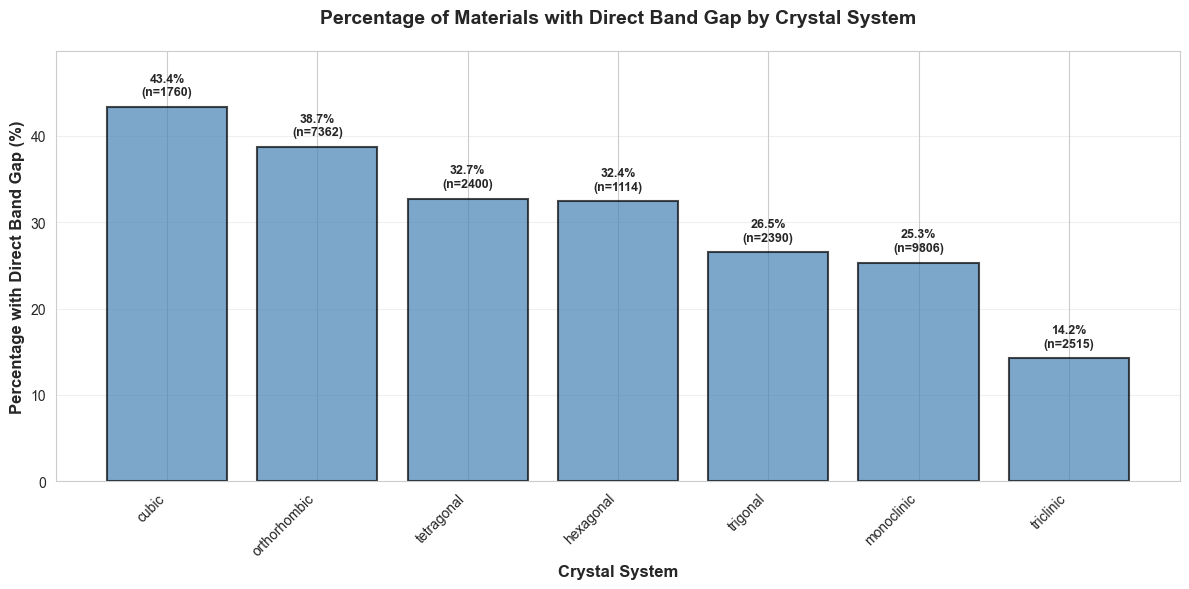


=== Key Observations ===
Highest % direct: cubic (43.4%)
Lowest % direct: triclinic (14.2%)


In [13]:
# Calculate percentage of direct band gap materials by crystal system
crystal_systems = mpids.groupby('symmetry.crystal_system')['is_gap_direct'].agg(['sum', 'count'])
crystal_systems['percentage_direct'] = (crystal_systems['sum'] / crystal_systems['count']) * 100
crystal_systems = crystal_systems.sort_values('percentage_direct', ascending=False)

print("Percentage of Direct Band Gap by Crystal System:")
print(crystal_systems)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(crystal_systems.index, crystal_systems['percentage_direct'], 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (idx, row) in enumerate(crystal_systems.iterrows()):
    plt.text(i, row['percentage_direct'] + 1, 
             f"{row['percentage_direct']:.1f}%\n(n={int(row['count'])})", 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Crystal System', fontsize=12, fontweight='bold')
plt.ylabel('Percentage with Direct Band Gap (%)', fontsize=12, fontweight='bold')
plt.title('Percentage of Materials with Direct Band Gap by Crystal System', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(crystal_systems['percentage_direct']) * 1.15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save figure
os.makedirs('../data', exist_ok=True)
plt.savefig('../data/direct_bandgap_by_crystal_system.png', dpi=150, bbox_inches='tight')
print("\n✓ Figure saved to: ../data/direct_bandgap_by_crystal_system.png")
plt.show()

print("\n=== Key Observations ===")
print(f"Highest % direct: {crystal_systems.index[0]} ({crystal_systems['percentage_direct'].iloc[0]:.1f}%)")
print(f"Lowest % direct: {crystal_systems.index[-1]} ({crystal_systems['percentage_direct'].iloc[-1]:.1f}%)")

Average Band Gap Comparison:
                       mean       std  count
Indirect Band Gap  2.415272  1.666506  19115
Direct Band Gap    2.571926  1.727182   8232

✓ Figure saved to: ../data/average_bandgap_comparison.png


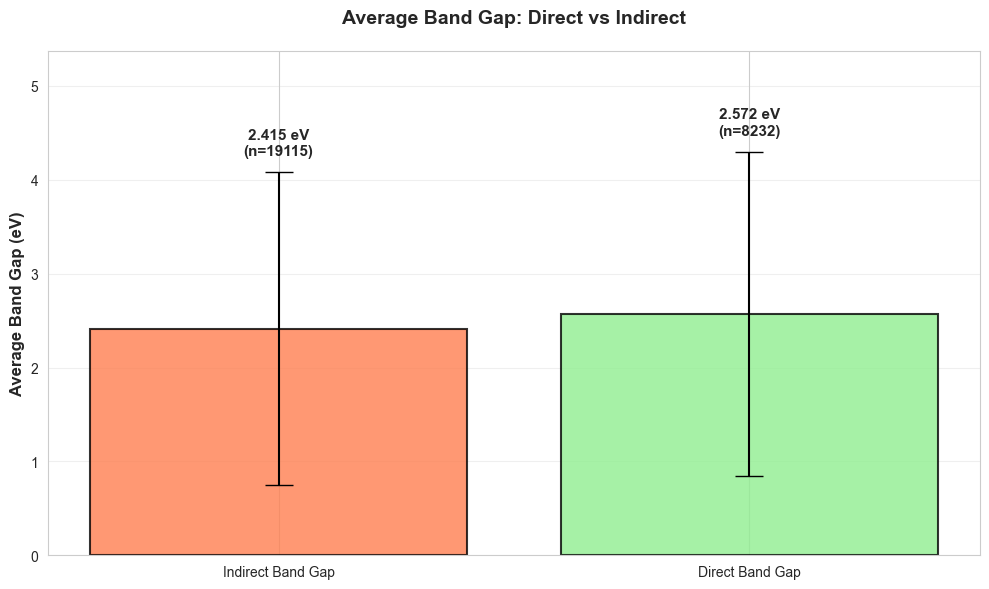


=== Analysis ===
Difference in average band gap: 0.157 eV
→ No significant difference observed.


In [14]:
# Calculate average band gap for direct vs indirect
bandgap_comparison = mpids.groupby('is_gap_direct')['band_gap'].agg(['mean', 'std', 'count'])
bandgap_comparison.index = ['Indirect Band Gap', 'Direct Band Gap']

print("Average Band Gap Comparison:")
print(bandgap_comparison)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(bandgap_comparison.index, bandgap_comparison['mean'], 
               yerr=bandgap_comparison['std'], capsize=10,
               color=['coral', 'lightgreen'], alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (idx, row) in enumerate(bandgap_comparison.iterrows()):
    plt.text(i, row['mean'] + row['std'] + 0.15, 
             f"{row['mean']:.3f} eV\n(n={int(row['count'])})", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel('Average Band Gap (eV)', fontsize=12, fontweight='bold')
plt.title('Average Band Gap: Direct vs Indirect', fontsize=14, fontweight='bold', pad=20)
plt.ylim(0, max(bandgap_comparison['mean'] + bandgap_comparison['std']) * 1.25)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save figure
plt.savefig('../data/average_bandgap_comparison.png', dpi=150, bbox_inches='tight')
print("\n✓ Figure saved to: ../data/average_bandgap_comparison.png")
plt.show()

print("\n=== Analysis ===")
diff = abs(bandgap_comparison.loc['Direct Band Gap', 'mean'] - 
           bandgap_comparison.loc['Indirect Band Gap', 'mean'])
print(f"Difference in average band gap: {diff:.3f} eV")
if diff > 0.5:
    print("→ PRONOUNCED difference observed!")
elif diff > 0.2:
    print("→ Moderate difference observed.")
else:
    print("→ No significant difference observed.")

In [15]:
print("="*70)
print("ASSIGNMENT 2 SUMMARY")
print("="*70)

print("\n1. TRENDS BY CRYSTAL SYSTEM:")
print("-" * 70)
for idx, row in crystal_systems.iterrows():
    print(f"  {idx:15s}: {row['percentage_direct']:5.1f}% direct (n={int(row['count'])})")

print("\n2. DIRECT VS INDIRECT BAND GAP:")
print("-" * 70)
print(f"  Direct:   {bandgap_comparison.loc['Direct Band Gap', 'mean']:.3f} ± {bandgap_comparison.loc['Direct Band Gap', 'std']:.3f} eV")
print(f"  Indirect: {bandgap_comparison.loc['Indirect Band Gap', 'mean']:.3f} ± {bandgap_comparison.loc['Indirect Band Gap', 'std']:.3f} eV")
print(f"  Difference: {diff:.3f} eV")


ASSIGNMENT 2 SUMMARY

1. TRENDS BY CRYSTAL SYSTEM:
----------------------------------------------------------------------
  cubic          :  43.4% direct (n=1760)
  orthorhombic   :  38.7% direct (n=7362)
  tetragonal     :  32.7% direct (n=2400)
  hexagonal      :  32.4% direct (n=1114)
  trigonal       :  26.5% direct (n=2390)
  monoclinic     :  25.3% direct (n=9806)
  triclinic      :  14.2% direct (n=2515)

2. DIRECT VS INDIRECT BAND GAP:
----------------------------------------------------------------------
  Direct:   2.572 ± 1.727 eV
  Indirect: 2.415 ± 1.667 eV
  Difference: 0.157 eV


In [16]:
print("="*70)
print("OBSERVATIONS")
print("="*70)

print("\n1. TRENDS BY CRYSTAL SYSTEM:")
print("-" * 70)
print("""
Looking at the data, cubic systems have way more direct band gaps (43.4%) 
compared to the other crystal systems. This actually makes sense since cubic 
structures are highly symmetric, so the band extrema are more likely to line 
up at the same k-point.

There's a pretty clear pattern here: the more symmetric the crystal system, 
the more likely it is to have a direct band gap. Cubic and orthorhombic are 
at the top (43% and 39%), while triclinic (which is the least symmetric) 
only has 14.2% direct band gaps.

What's interesting is that triclinic and monoclinic (the low symmetry ones) 
together make up a huge portion of the dataset, but 
they have the lowest percentages of direct band gaps. For materials science 
applications like solar cells where you want direct band gaps, this 
suggests you'd have better luck searching in cubic or orthorhombic systems.
""")

print("\n2. DIRECT VS INDIRECT BAND GAP VALUES:")
print("-" * 70)
print("""
Honestly, the difference in average band gap values is pretty small (only 
0.157 eV). Direct band gaps average 2.572 eV and indirect ones average 2.415 eV. 
Given that both have standard deviations around 1.7 eV, this difference isn't 
really significant.

So whether a material has a direct or indirect band gap doesn't really tell 
you much about how big the gap will be. The band gap size depends more on the 
material's chemistry and electronic structure, while the direct vs indirect 
nature depends on the symmetry and how the bands are arranged in k-space.
""")

print("\n" + "="*70)

OBSERVATIONS

1. TRENDS BY CRYSTAL SYSTEM:
----------------------------------------------------------------------

Looking at the data, cubic systems have way more direct band gaps (43.4%) 
compared to the other crystal systems. This actually makes sense since cubic 
structures are highly symmetric, so the band extrema are more likely to line 
up at the same k-point.

There's a pretty clear pattern here: the more symmetric the crystal system, 
the more likely it is to have a direct band gap. Cubic and orthorhombic are 
at the top (43% and 39%), while triclinic (which is the least symmetric) 
only has 14.2% direct band gaps.

What's interesting is that triclinic and monoclinic (the low symmetry ones) 
together make up a huge portion of the dataset, but 
they have the lowest percentages of direct band gaps. For materials science 
applications like solar cells where you want direct band gaps, this 
suggests you'd have better luck searching in cubic or orthorhombic systems.


2. DIRECT VS 